In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import torch
from torch import optim
from torchvision import models
from torchvision.utils import make_grid, save_image

from vae import ConvVAE, VAEConfig, get_vae_trainer
from __datasets__ import CelebADataset
from utils.benchmark import PerceptualLoss, train, test
from utils.display import display_images
from utils.checkpoints import save_checkpoint, load_checkpoint

In [39]:
config1 = VAEConfig(
    "../../pytorch/datasets/celeb-a",
    "VaeTest",
    "v1",
    image_shape=(3, 64, 64),
    latent_dim=128,
    dropout=0, n=1,
    lambdas=(0.001,),
    num_epochs=1, batch_size=32,
    lr=1e-3,
    blocks=(32, 64, 96, 128),
    writer=False,
)

In [40]:
ds1 = CelebADataset(config1.dataset_path, download=True, image_transform=config1.transforms, sub_sample=0.1)

In [41]:
vae_model = ConvVAE(
    config1.image_shape[0],
    config1.latent_dim,
    config1.blocks,
    n=config1.n,
    p=config1.dropout,
    norm=1,
).to(config1.device)

In [24]:
fixed = ds1[:9]
fixed = fixed["image"]
vae_model = vae_model.eval()
with torch.inference_mode():
    print(fixed.shape)
    %timeit vae_model(fixed)

torch.Size([9, 3, 64, 64])


KeyboardInterrupt: 

In [42]:
perceptual_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:29].eval().to(config1.device)
perceptual_loss = PerceptualLoss(perceptual_model)
optimizer = optim.Adam(vae_model.parameters(), lr=config1.lr)
step_offset = 0

In [43]:
if input("Load Model? [y/n] ").lower() == "y":
    path = input("Path: ")
    others = load_checkpoint(
        path,
        {"vae_model": vae_model},
        {"optimizer": optimizer},
        device=config1.device,
    )
    step_offset = others["step"]

In [44]:
fixed = ds1[:9]
fixed = fixed["image"]
trainer = get_vae_trainer(
    vae_model,
    optimizer,
    save_path=config1.checkpoint_path, save_period=200,
    perceptual_loss=None,
    lambda_kl=config1.lambdas[0],
    writer=config1.writer, writer_period=100,
    fixed=fixed,
)

In [45]:
vae_model = vae_model.train()
step_offset = train(
    trainer,
    ds1, ne=1, bs=config1.batch_size,
    step_offset=step_offset,
)

Epoch: 0/1 | Batch 0/634|          |  0% [00:00<?, ?it/s , loss=?]

/Users/amith.m/PycharmProjects/genai/src/vae/benchmark.py:34: UserWarning: Using a target size (torch.Size([32, 3, 64, 64])) that is different to the input size (torch.Size([32, 3, 49, 49])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_reconstruction = F.cross_entropy(fake, real, reduction="none").sum(axis=(1, 2, 3)).mean()


RuntimeError: The size of tensor a (49) must match the size of tensor b (64) at non-singleton dimension 3

In [19]:
vae_model = vae_model.eval()
test

<function utils.benchmark.test(tester: Callable[[dict[str, 'torch.Tensor']], dict[str, float]], ds: 'Dataset', bs: int = 32, collate_fn: Callable[[list[dict[str, 'torch.Tensor']]], dict[str, 'torch.Tensor']] = None)>

In [ ]:
save_checkpoint(
    config1.checkpoint_path,
    {"vae_model": vae_model},
    {"optimizer": optimizer},
    step=step_offset,
)

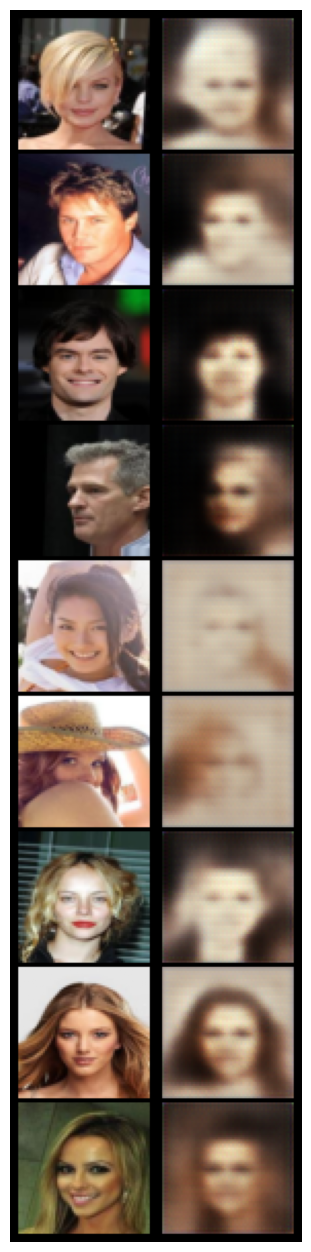

CPU times: user 645 ms, sys: 43.4 ms, total: 689 ms
Wall time: 328 ms


In [19]:
%%time

vae_model = vae_model.eval()
fixed = ds1[0:9]
fixed = fixed["image"]
with torch.inference_mode():
    grid_real = make_grid(fixed, nrow=1, normalize=True)
    grid_fake = make_grid(vae_model(fixed), nrow=1, normalize=True)
    grid = make_grid(torch.stack([grid_real, grid_fake]), nrow=2, normalize=True)
display_images(grid.permute(1, 2, 0).cpu().unsqueeze(0))

In [54]:
 save_image

<function torchvision.utils.save_image(tensor: Union[torch.Tensor, List[torch.Tensor]], fp: Union[str, pathlib.Path, BinaryIO], format: Optional[str] = None, **kwargs) -> None>